In [4]:
img1 = r'd:\Downloads\17-104062-57710.png'
img1 = r'17-104062-57710.png'
img2 = r'1m 18,208745,123179,meey 2.png'

In [4]:
import gdal

ModuleNotFoundError: No module named 'gdal'

In [ ]:
path = r'E:\GitHub\py_utils\GDAL-3.8.2-cp312-cp312-win_amd64.whl'

In [ ]:
from osgeo import gdal

# Open a raster file
dataset = gdal.Open('path_to_your_raster_file.tif')

# Get raster band
band = dataset.GetRasterBand(1)

# Read raster data as an array
array = band.ReadAsArray()

print(array)


In [5]:
import sys
from osgeo import gdal, ogr

def polygonize_png(input_png, output_shp):
    # Open the PNG file
    src_ds = gdal.Open(input_png)
    if src_ds is None:
        print('Unable to open', input_png)
        sys.exit(1)

    # Read the first band
    srcband = src_ds.GetRasterBand(1)

    # Create the destination data source
    dst_layername = "polygonized"
    drv = ogr.GetDriverByName("ESRI Shapefile")
    dst_ds = drv.CreateDataSource(output_shp)
    dst_layer = dst_ds.CreateLayer(dst_layername, srs=None)

    # Add a field to the layer
    fd = ogr.FieldDefn("DN", ogr.OFTInteger)
    dst_layer.CreateField(fd)

    # Polygonize
    gdal.Polygonize(srcband, None, dst_layer, 0, [], callback=gdal.TermProgress_nocb)

    # Close the datasets
    src_ds = None
    dst_ds = None

    print(f"Polygonization complete. Output saved to {output_shp}")

# Usage
input_png = img2
output_shp = 'polygons.shp'
polygonize_png(input_png, output_shp)

Polygonization complete. Output saved to polygons.shp


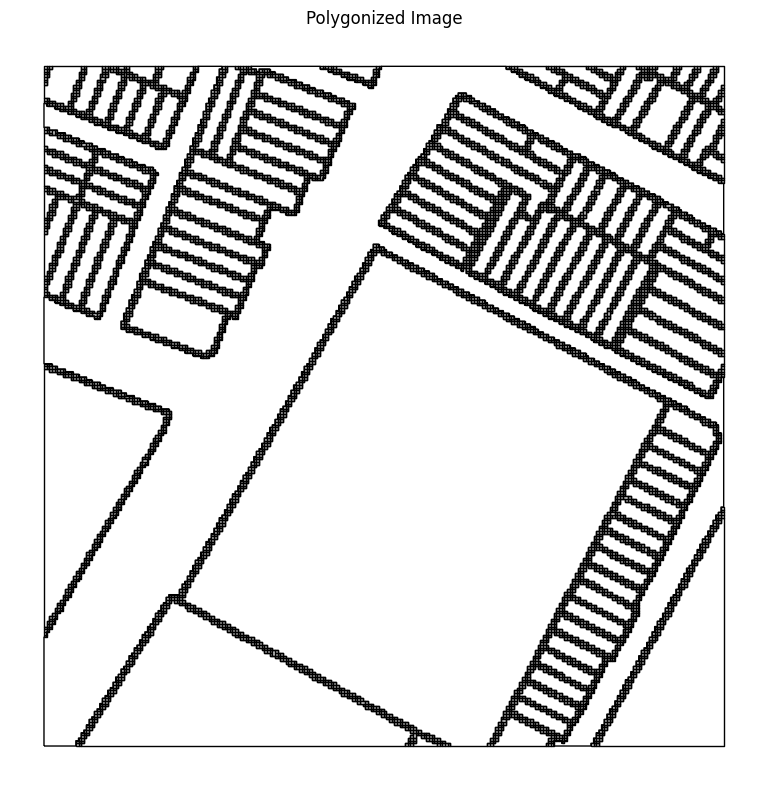

Number of polygons: 9563

First few rows of attribute table:
    DN                                       geometry
0  148       POLYGON ((12 0, 12 1, 13 1, 13 0, 12 0))
1  153       POLYGON ((13 0, 13 1, 14 1, 14 0, 13 0))
2   18  POLYGON ((136 0, 136 1, 137 1, 137 0, 136 0))
3  238  POLYGON ((137 0, 137 1, 138 1, 138 0, 137 0))
4  167  POLYGON ((138 0, 138 1, 139 1, 139 0, 138 0))


In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

def view_shapefile(shapefile_path):
    # Read the shapefile
    gdf = gpd.read_file(shapefile_path)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the shapefile
    gdf.plot(ax=ax, edgecolor='black', facecolor='none')

    # Remove axis
    ax.axis('off')

    # Add a title
    plt.title('Polygonized Image')

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Print some information about the shapefile
    print(f"Number of polygons: {len(gdf)}")
    print("\nFirst few rows of attribute table:")
    print(gdf.head())

# Usage
shapefile_path = 'polygons.shp'
view_shapefile(shapefile_path)

In [7]:
import sys
import numpy as np
from osgeo import gdal, ogr, osr

def polygonize_transparent_png(input_png, output_shp):
    # Open the PNG file
    src_ds = gdal.Open(input_png)
    if src_ds is None:
        print('Unable to open', input_png)
        sys.exit(1)

    # Read all bands
    band_data = []
    for i in range(1, src_ds.RasterCount + 1):
        band = src_ds.GetRasterBand(i)
        band_data.append(band.ReadAsArray())

    # Combine bands to create a mask where lines are 1 and background is 0
    if len(band_data) == 4:  # RGBA
        # Assuming lines are black (0,0,0) and everything else is either white or transparent
        mask = np.logical_and(
            np.logical_and(band_data[0] == 0, band_data[1] == 0),
            np.logical_and(band_data[2] == 0, band_data[3] > 0)
        ).astype(np.uint8)
    elif len(band_data) == 3:  # RGB
        # Assuming lines are black (0,0,0) and everything else is white
        mask = np.logical_and(
            np.logical_and(band_data[0] == 0, band_data[1] == 0),
            band_data[2] == 0
        ).astype(np.uint8)
    else:
        print('Unsupported number of bands')
        sys.exit(1)

    # Create a new raster for the mask
    driver = gdal.GetDriverByName('MEM')
    mask_ds = driver.Create('', src_ds.RasterXSize, src_ds.RasterYSize, 1, gdal.GDT_Byte)
    mask_ds.GetRasterBand(1).WriteArray(mask)

    # Set the projection and geotransform of the mask to match the input
    mask_ds.SetProjection(src_ds.GetProjection())
    mask_ds.SetGeoTransform(src_ds.GetGeoTransform())

    # Create the shapefile
    shp_driver = ogr.GetDriverByName("ESRI Shapefile")
    shp_ds = shp_driver.CreateDataSource(output_shp)
    srs = osr.SpatialReference()
    srs.ImportFromWkt(src_ds.GetProjectionRef())
    layer = shp_ds.CreateLayer("polygons", srs=srs)

    # Add a field to the layer
    fd = ogr.FieldDefn("DN", ogr.OFTInteger)
    layer.CreateField(fd)

    # Polygonize
    gdal.Polygonize(mask_ds.GetRasterBand(1), None, layer, 0, [], callback=gdal.TermProgress_nocb)

    # Close the datasets
    src_ds = None
    mask_ds = None
    shp_ds = None

    print(f"Polygonization complete. Output saved to {output_shp}")

# Usage
input_png = img2
output_shp = 'path/to/your/output/polygons.shp'
polygonize_transparent_png(input_png, output_shp)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Chill\miniconda3\envs\async0\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\Chill\miniconda3\envs\async0\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\Chill\miniconda3\envs\async0\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File 

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



ImportError: numpy.core.multiarray failed to import

In [9]:
import cv2
import numpy as np
from shapely.geometry import LineString, mapping
import fiona
from fiona.crs import from_epsg

# Load the image
image_path = img2  # Replace with your image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Thresholding the image to binary
_, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Find contours (edges) in the binary image
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert contours to LineString objects
line_strings = []
for contour in contours:
    # Approximate the contour with a polyline
    approx = cv2.approxPolyDP(contour, epsilon=2, closed=False)
    points = [(point[0][0], point[0][1]) for point in approx]
    line_string = LineString(points)
    line_strings.append(line_string)

# Define schema for the shapefile
schema = {
    'geometry': 'LineString',
    'properties': {'id': 'int'},
}

# Create a shapefile and write the LineString objects
shapefile_path = 'output_shapefile.shp'  # Replace with desired output path
with fiona.open(shapefile_path, 'w', driver='ESRI Shapefile', crs=from_epsg(4326), schema=schema) as shp:
    for i, line_string in enumerate(line_strings):
        shp.write({
            'geometry': mapping(line_string),
            'properties': {'id': i},
        })

print(f'Shapefile saved to {shapefile_path}')


Shapefile saved to output_shapefile.shp


In [10]:
import cv2
import numpy as np
from shapely.geometry import LineString, mapping
import fiona
from fiona.crs import from_epsg

# Load the image
image_path = img2  # Replace with your image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Thresholding the image to binary
_, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Find contours (edges) in the binary image
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert contours to LineString objects
line_strings = []
for contour in contours:
    # Approximate the contour with a polyline
    approx = cv2.approxPolyDP(contour, epsilon=2, closed=False)
    points = [(point[0][0], point[0][1]) for point in approx]
    line_string = LineString(points)
    line_strings.append(line_string)

# Define schema for the GeoJSON file
schema = {
    'geometry': 'LineString',
    'properties': {'id': 'int'},
}

# Create a GeoJSON file and write the LineString objects
geojson_path = 'output_file.geojson'  # Replace with desired output path
with fiona.open(geojson_path, 'w', driver='GeoJSON', crs=from_epsg(4326), schema=schema) as geojson:
    for i, line_string in enumerate(line_strings):
        geojson.write({
            'geometry': mapping(line_string),
            'properties': {'id': i},
        })

print(f'GeoJSON file saved to {geojson_path}')


GeoJSON file saved to output_file.geojson


ValueError: aspect must be finite and positive 

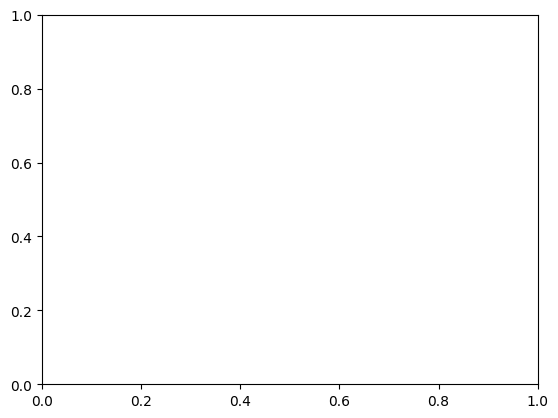

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Path to the GeoJSON file
geojson_path = 'output_file.geojson'  # Replace with your GeoJSON file path

# Read the GeoJSON file using GeoPandas
gdf = gpd.read_file(geojson_path)

# Plot the GeoDataFrame
gdf.plot()
plt.title('GeoJSON Lines')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [12]:
import sys
import numpy as np
from osgeo import gdal, ogr, osr

def polygonize_transparent_png(input_png, output_shp):
    # Open the PNG file
    src_ds = gdal.Open(input_png)
    if src_ds is None:
        print('Unable to open', input_png)
        sys.exit(1)

    # Read all bands
    band_data = []
    for i in range(1, src_ds.RasterCount + 1):
        band = src_ds.GetRasterBand(i)
        band_data.append(band.ReadAsArray())

    # Combine bands to create a mask where lines are 1 and background is 0
    if len(band_data) == 4:  # RGBA
        # Assuming lines are black (0,0,0) and everything else is either white or transparent
        mask = np.logical_and(
            np.logical_and(band_data[0] == 0, band_data[1] == 0),
            np.logical_and(band_data[2] == 0, band_data[3] > 0)
        ).astype(np.uint8)
    elif len(band_data) == 3:  # RGB
        # Assuming lines are black (0,0,0) and everything else is white
        mask = np.logical_and(
            np.logical_and(band_data[0] == 0, band_data[1] == 0),
            band_data[2] == 0
        ).astype(np.uint8)
    else:
        print('Unsupported number of bands')
        sys.exit(1)

    # Create a new raster for the mask
    driver = gdal.GetDriverByName('MEM')
    mask_ds = driver.Create('', src_ds.RasterXSize, src_ds.RasterYSize, 1, gdal.GDT_Byte)
    mask_ds.GetRasterBand(1).WriteArray(mask)

    # Set the projection and geotransform of the mask to match the input
    mask_ds.SetProjection(src_ds.GetProjection())
    mask_ds.SetGeoTransform(src_ds.GetGeoTransform())

    # Create the shapefile
    shp_driver = ogr.GetDriverByName("ESRI Shapefile")
    shp_ds = shp_driver.CreateDataSource(output_shp)
    srs = osr.SpatialReference()
    srs.ImportFromWkt(src_ds.GetProjectionRef())
    layer = shp_ds.CreateLayer("polygons", srs=srs)

    # Add a field to the layer
    fd = ogr.FieldDefn("DN", ogr.OFTInteger)
    layer.CreateField(fd)

    # Polygonize
    gdal.Polygonize(mask_ds.GetRasterBand(1), None, layer, 0, [], callback=gdal.TermProgress_nocb)

    # Close the datasets
    src_ds = None
    mask_ds = None
    shp_ds = None

    print(f"Polygonization complete. Output saved to {output_shp}")

# Usage
input_png = img2
output_shp = 'output/polygons.shp'
polygonize_transparent_png(input_png, output_shp)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Chill\miniconda3\envs\async0\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\Chill\miniconda3\envs\async0\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\Chill\miniconda3\envs\async0\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File 

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



ImportError: numpy.core.multiarray failed to import